# Introduction to Multilayer Perceptrons (MLP)

In this tutorial we will introduce an MLP for forecasting a time-series.

*Remark:* This is an tutorial which intends to introduce MLPs. MLPs are usually not the best NN architectures for time series forecasting because they often do not capture the autocorrelation.

The following packages are needed for this tutorial:

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
import nc_time_axis
plt.style.use("./../plotting.mplstyle")

## 1. Reading and plotting the input data 

Any time-series would do the job. Here, we use the Nino3.4 index of CESM2 piControl run.

We use xarray to read the .nc files:

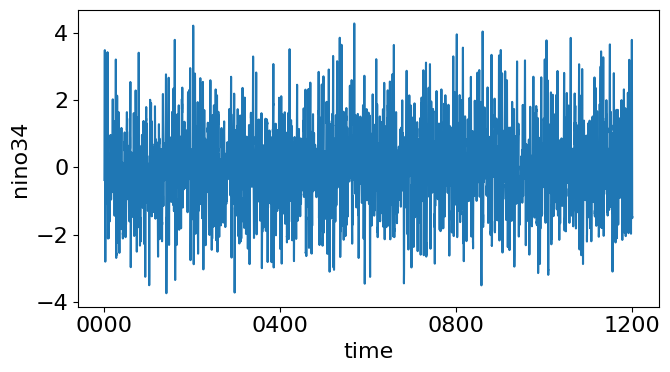

In [2]:
da = xr.open_dataset("./data/nino34_CESM2_piControl_amon.nc")['nino34']
_ = da.plot()

## 2. Preprocess data for our deep learning framework

There are a whole zoo of deep learning libraries for python out there.

![ML](img/dl_libraries.png) [Ref.](https://towardsdatascience.com/best-python-libraries-for-machine-learning-and-deep-learning-b0bd40c7e8c)

Here, we use pytorch because it easily allows running your code on GPUs.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Pytorch use their own datatype, pytorch.Tensors which is very similar to numpy. The following preprocessing steps are usually required: 

1. **Normalization**: Data should be normalized because the weights of the NN are initialized randomly around 0.

In [4]:
data_mean = np.mean(da.data)
data_std = np.std(da.data)
da_norm = (da - data_mean) / data_std 

2. **Split data into training, validation and test set** usually by ration 70%, 20%, 10%

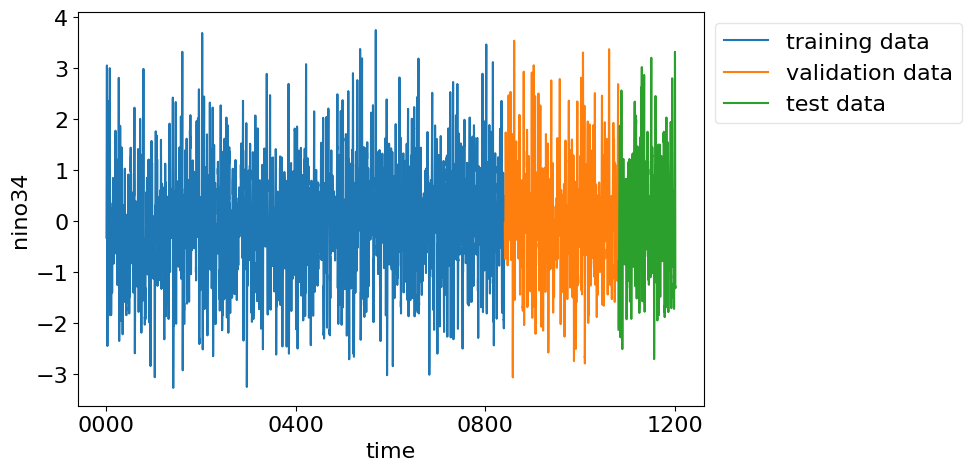

In [5]:
n_train = int(len(da_norm['time']) * 0.7)
n_val = int(len(da_norm['time']) * 0.2)
train_data = da_norm[: n_train]
val_data = da_norm[n_train: n_train+n_val]
test_data = da_norm[n_train+n_val: ]

# Plotting
fig, ax = plt.subplots(figsize=(10,5))
train_data.plot(ax=ax, label='training data')
val_data.plot(ax=ax, label='validation data')
test_data.plot(ax=ax, label='test data')
_ = ax.legend(bbox_to_anchor=(1,1), loc="upper left")

3. **Convert to torch.Tensor**: It is convinient to define a Dataset class so that we can use the Dataloader objects predefined by pytorch. 

To process a datapoints in parallel pytorch offers a ```Dataloader```. The Dataloader allows to process a set of datapoints, i.e. minibatch at the same time. The size of the minibatch depends on the number of datapoints we have. 

In [6]:
class TimeSeries(Dataset):
    def __init__(self, dataarray, n_input, lag):
        self.n_input = n_input
        self.lag = lag
        self.dataarray = dataarray

    def __len__(self):
        return len(self.dataarray['time']) - (self.n_input + self.lag)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = self.dataarray.isel(time=slice(idx, idx+self.n_input))
        target = self.dataarray.isel(time=idx+self.n_input+self.lag-1)

        input = torch.from_numpy(input.data).float()
        target = torch.from_numpy(target.data[np.newaxis]).float()

        label = {
            'idx_input': torch.arange(idx, idx+self.n_input),
            'idx_target': idx+self.n_input+self.lag-1
        }

        return input, target, label   
        
# Convert to torch.Dataset
n_input = 6
lag = 1
batch_size = 32

train_dataset = TimeSeries(train_data, n_input, lag)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TimeSeries(val_data, n_input, lag)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

Lets have a look at our pytoch Dataset class.

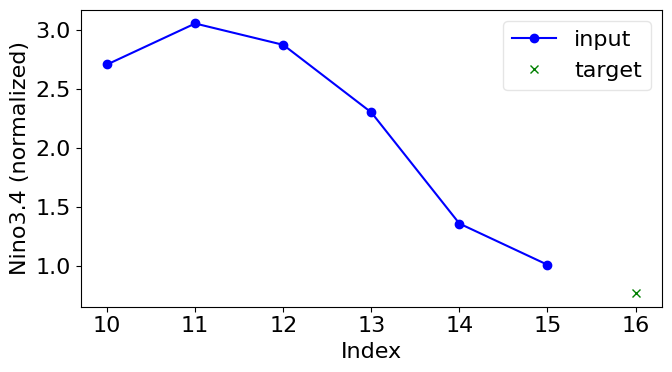

In [7]:
# Sample datapoint
input, target, l = train_dataset[10]

fig, ax = plt.subplots()
ax.plot(l['idx_input'], input, 'bo-', label='input')
ax.plot(l['idx_target'], target, 'gx', label='target')
ax.set_xlabel("Index")
ax.set_ylabel("Nino3.4 (normalized)")
_ = ax.legend()

## 3. Training a Multilayer Perceptron


**Perceptron**:

<img src="img/perceptron.png" width="500"> [Ref.](https://commons.wikimedia.org/wiki/File:Perceptron_moj.png)

The building block of a MLP is the perceptron which takes input vector $\mathbf{x} = (x_1, \ldots, x_n)$. \
The input is multiplied by the weights $\mathbf{w} = (w_1, \ldots, w_n)$ and are added together with a bias $w_0$. \
The sum is passed through a non-linear function $f$, called the activation function:

$y = f\left( \sum_n x_n * w_n + w_0 \right)$

The most common used activation functions are ReLU, Sigmoid, tanh, ...


**Multilayer Perceptron**:

Combining perceptrons into a neural network by taking the output of the first layer as an input the the next layer.

<img src="img/nn.png" width="500"> [Ref.](http://alexlenail.me/NN-SVG/index.html)


### 3.1. Define an MLP

We have to make the following choices when building an MLP:

1. **Number of hidden layers**
2. **Dimension of the hidden layers**
3. **Activation function**


In [8]:
input_dim = n_input
output_dim = 1
hidden_dim = 32

mlp = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
)

In [9]:
# Forward pass f(x)
x, t, l = train_dataset[5]
out = mlp(x)
print(f"Input: {x}")
print(f"Target: {t}")
print(f"Prediction: {out}")

Input: tensor([0.7763, 0.9775, 1.4985, 2.0271, 2.4183, 2.7044])
Target: tensor([3.0512])
Prediction: tensor([-0.2543], grad_fn=<AddBackward0>)


**How many parameters does our model have?**

$N_p = n_{in}*n_{hid} + n_{hid} + n_{hid}*n_{out} + n_{out}$

In [10]:
if True:
    print('Number weights:', (input_dim*hidden_dim + hidden_dim + hidden_dim*output_dim + output_dim))
    
    print("Number of trainable parameters of our model:",
          sum(p.numel() for p in mlp.parameters() if p.requires_grad))

Number weights: 257
Number of trainable parameters of our model: 257


### 3.2. Training the model

We train the NN by computing the loss for each minibatch and update the gradients using backpropagation. We iterate $N$ epochs over the whole training data.

We have to set the following hyperparameters for training:

1. **Loss function**: We choose the mean-square error function because the data are Gaussian distributed:

    $L(\mathbf{w})=\frac{1}{n} \sum_{i=1}^{n}\left( \mathbf{x}^{(i)} - f_{\mathbf{w}}\left(\mathbf{x}^{(i)}\right)\right)^{2}$

2. **Optimizer**: Optimization algorithm to find the minimum of the loss function wrt. to the weights $\mathbf{w}$, e.g. Adam, SGD, BFGS, ...

3. **Learning rate $\alpha$**: The learning rate determines the update of the weights for the respective optimizer
    
    $\mathbf{w_{i+1}} = \mathbf{w_i} - \alpha \cdot \frac{\partial L }{\partial\mathbf{w_i}}$

4. **Epochs**: The number of epochs specifies how often we iterate over the training dataset. We choose the number of epochs such that the validation loss is converged. 



In [11]:
# Set parameters
epochs = 10
learning_rate = 0.001
loss_fn = F.mse_loss
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We iterate over the training data and validation data for each epoch.

In [12]:
def training(mlp, loss_fn, optimizer, train_loader,  val_loader, device='cpu'):
    """Training function of model for one epoch.
    """
    mlp = mlp.to(device)

    # Validation
    # =============================================
    mlp.eval()

    val_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            input, target, _ = data

            # Forward pass
            pred = mlp(input.to(device)) 

            # loss function
            loss = loss_fn(target.to(device), pred)
            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_loader)
    
    
    # Training 
    # =============================================
    # set model into training mode
    mlp.train()

    train_loss = 0.0
    for i, data in enumerate(train_loader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        input, target, _ = data

        # Forward pass
        pred = mlp(input.to(device)) 

        # loss function
        loss = loss_fn(target.to(device), pred)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    mean_train_loss = train_loss / len(train_loader)

    return mean_train_loss, mean_val_loss

In [13]:
# The training loop
train_loss = []
val_loss = []
for epoch in range(epochs):
    train_epoch_loss, val_epoch_loss = training(
        mlp, loss_fn, optimizer, train_dataloader, val_dataloader, device=device
    )
    print(f"Epoch {epoch+1} of {epochs}, train. loss: {train_epoch_loss:.4f}, val. loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 10, train. loss: 0.3574, val. loss: 1.7295
Epoch 2 of 10, train. loss: 0.0729, val. loss: 0.0781
Epoch 3 of 10, train. loss: 0.0618, val. loss: 0.0649
Epoch 4 of 10, train. loss: 0.0545, val. loss: 0.0565
Epoch 5 of 10, train. loss: 0.0498, val. loss: 0.0513
Epoch 6 of 10, train. loss: 0.0462, val. loss: 0.0477
Epoch 7 of 10, train. loss: 0.0438, val. loss: 0.0450
Epoch 8 of 10, train. loss: 0.0422, val. loss: 0.0434
Epoch 9 of 10, train. loss: 0.0411, val. loss: 0.0427
Epoch 10 of 10, train. loss: 0.0402, val. loss: 0.0406


# 4. Evaluation

## 4.1. Convergence of loss

The first evaluation of the training is by plotting the loss on the training data and on the validation data for each epoch:

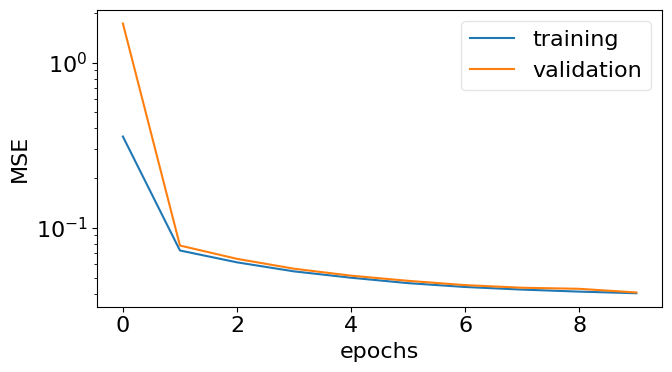

In [14]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
_ = ax.legend()

## 4.2. Visualizing prediction

We take a random example and look at the prediction:

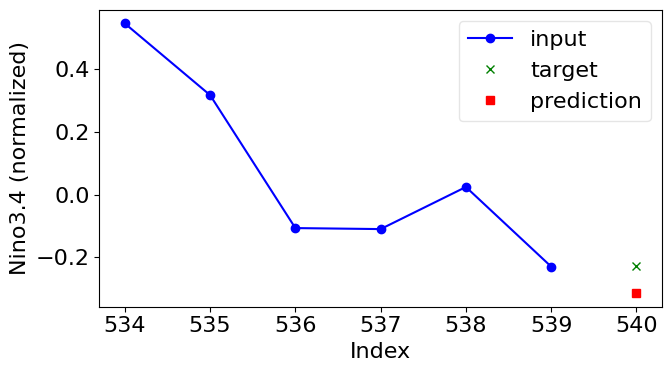

In [33]:
# Random datapoint from validation set
input, target, l = val_dataset[np.random.randint(len(val_dataset))]
pred = mlp(input.to(device)) 

fig, ax = plt.subplots()
ax.plot(l['idx_input'], input, 'bo-', label='input')
ax.plot(l['idx_target'], target, 'gx', label='target')
ax.plot(l['idx_target'], pred.cpu().detach().numpy(), 'rs', label='prediction')
ax.set_xlabel("Index")
ax.set_ylabel("Nino3.4 (normalized)")
_ = ax.legend()

Prediction of the validation data set.

In [21]:
with torch.no_grad():
    pred_storer = {'time':[], 'x':[], 'mse':[]}
    for i, data in enumerate(val_dataloader):
        input, target, l = data
        # Forward pass
        pred = mlp(input.to(device)) 
        pred_storer['x'].append(pred.cpu().numpy().flatten())
        pred_storer['time'].append(val_data['time'][l['idx_target']])
        pred_storer['mse'].append(
            loss_fn(pred, target.to(device), reduction='none').cpu().numpy().flatten()
        )

prediction = xr.DataArray(data=np.concatenate(pred_storer['x']),
                          coords={'time': np.concatenate(pred_storer['time'])}).sortby('time')
mse = xr.DataArray(data=np.concatenate(pred_storer['mse']),
                          coords={'time': np.concatenate(pred_storer['time'])}).sortby('time')


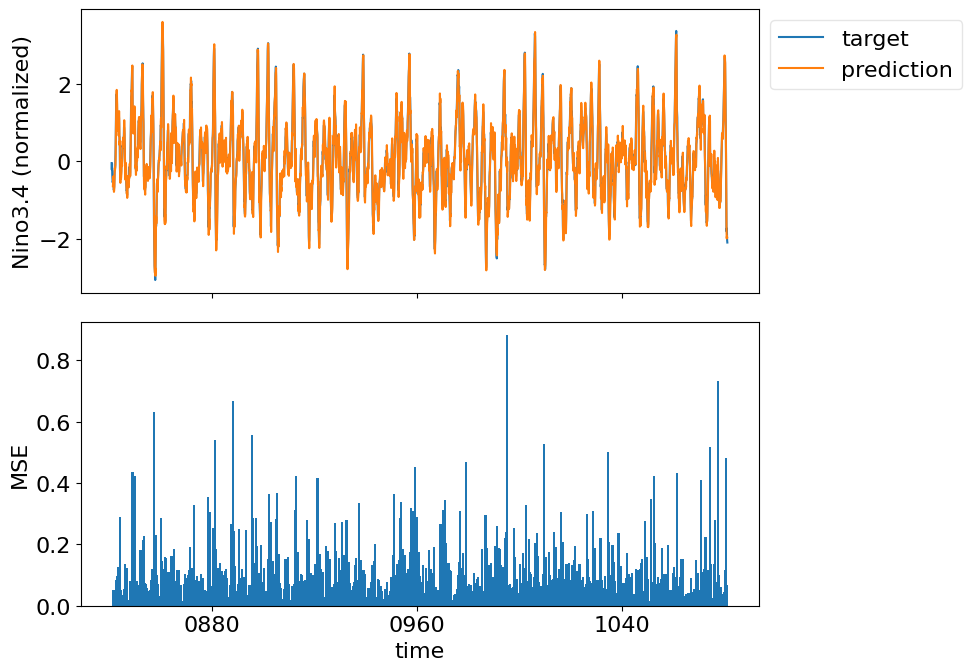

In [22]:
# Plot prediction
fig, axs = plt.subplots(2,1, sharex=True, figsize=(10,7))
axs[0].plot(val_data['time'], val_data.data, label='target')
axs[0].plot(prediction['time'], prediction.data, label='prediction')
axs[0].set_ylabel('Nino3.4 (normalized)')
axs[0].legend(bbox_to_anchor=(1,1), loc="upper left")

axs[1].bar(mse['time'].data, mse.data, width=3e2)
axs[1].set_ylabel('MSE')
_ = axs[1].set_xlabel('time')



### 4.3 Apply the MLP autoregressively

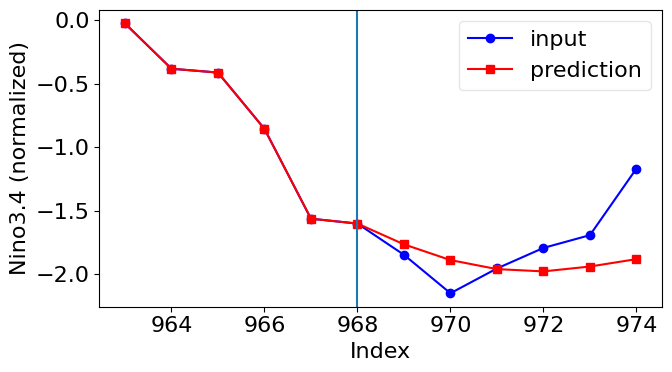

In [24]:
# Random datapoint from validation set
input, target, l = val_dataset[np.random.randint(len(val_dataset))]
x_ar = input
n_rollout = 6
for i in range(n_rollout):
    pred = mlp(x_ar[-input_dim:].to(device)) 
    x_ar = torch.concat([x_ar, pred.detach().cpu()])

ids = np.arange(l['idx_input'][0], l['idx_input'][-1]+n_rollout+1)
x_ar = xr.DataArray(data=x_ar, coords={'time': val_data['time'][ids]})

# Plotting rollout
fig, ax = plt.subplots()
ax.plot(ids, val_data.isel(time=ids).data, 'bo-', label='input')
ax.plot(ids, x_ar.data, 'rs-', label='prediction')
ax.set_xlabel("Index")
ax.set_ylabel("Nino3.4 (normalized)")
ax.legend()
_ = ax.axvline(ids[input_dim-1])

Prediction of the validation dataset using the MLP autoregressively.

In [27]:
n_rollout = 6
with torch.no_grad():
    pred_storer = {'time':[], 'x':[], 'mse':[]}
    for i, data in enumerate(val_dataset):
        input, target, l = data

        # Forward pass
        if l['idx_target']+n_rollout >= len(val_data['time']):
            continue
        
        x_ar = input
        for i in range(n_rollout):
            pred = mlp(x_ar[-input_dim:].to(device)) 
            x_ar = torch.concat([x_ar, pred.detach().cpu()])

        pred_storer['x'].append(pred.cpu().numpy())
        pred_storer['time'].append(val_data['time'][l['idx_target']+n_rollout])
        pred_storer['mse'].append(
            loss_fn(pred, torch.from_numpy(val_data.isel(time=l['idx_target']+n_rollout).data.flatten()).to(device),
                    reduction='none').cpu().numpy()
        )

prediction = xr.DataArray(data=np.array(pred_storer['x']).flatten(),
                          coords={'time': xr.concat(pred_storer['time'], dim='time')}).sortby('time')
mse = xr.DataArray(data=np.array(pred_storer['mse']).flatten(),
                   coords={'time': xr.concat(pred_storer['time'], dim='time')}).sortby('time')


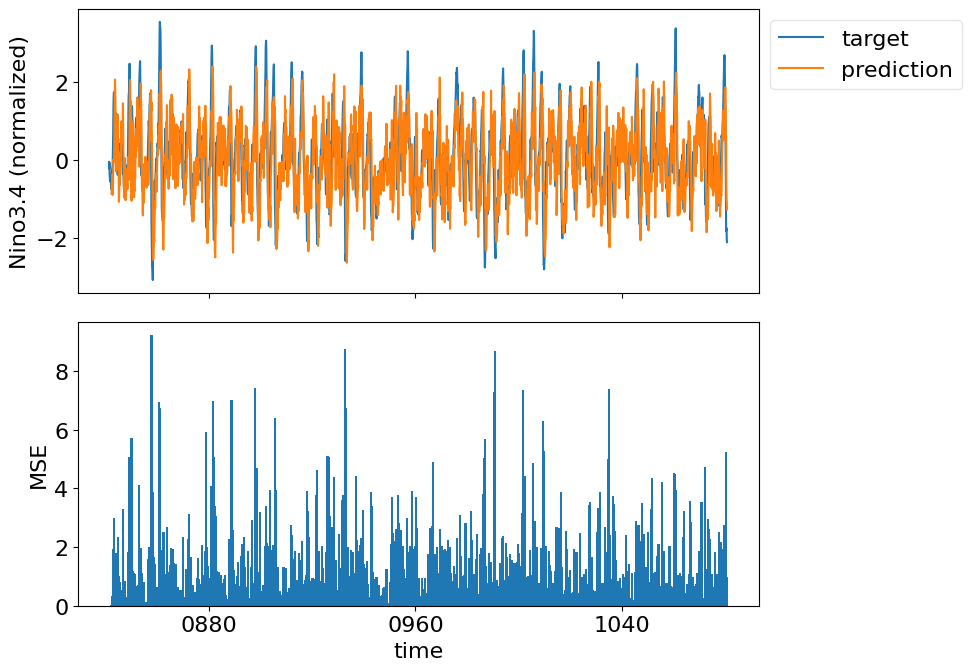

In [28]:
# Plot prediction
fig, axs = plt.subplots(2,1, sharex=True, figsize=(10,7))
axs[0].plot(val_data['time'], val_data.data, label='target')
axs[0].plot(prediction['time'], prediction.data, label='prediction')
axs[0].set_ylabel('Nino3.4 (normalized)')
axs[0].legend(bbox_to_anchor=(1,1), loc="upper left")

axs[1].bar(mse['time'].data, mse.data, width=3e2)
axs[1].set_ylabel('MSE')
_ = axs[1].set_xlabel('time')

## 5. Typical analysis for improvements

1. Increase the network until overfitting is reached

2. For non-Gaussian time-series use other loss functions or bin the values for a classification task

3. Use other network architectures, e.g. LSTMs for time-series

## More resources

1. [Bishop's book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)

2. [ML for Beginners](https://victorzhou.com/blog/intro-to-neural-networks/)

3. [Introduction to NN](http://mt-class.org/jhu/slides/lecture-nn-intro.pdf)

...
